In [12]:
import os
import glob
import imageio
import numpy as np
import scipy as sc

In [16]:
from  scipy import misc

In [19]:
from PIL import Image

In [32]:
import matplotlib.pyplot as plt

In [2]:
homedir = '/home/kurihana/class/MachineLearning_Kondor'

In [22]:
bgdatadir= homedir+'/background'
fcdatadir= homedir+'/faces'

In [23]:
len(glob.glob(bgdatadir+'/*jpg'))

2000

In [24]:
len(glob.glob(fcdatadir+'/*jpg'))

2000

In [25]:
backgrounds = glob.glob(bgdatadir+'/*jpg')

In [26]:
faces = glob.glob(fcdatadir+'/*jpg')

### load data and gray scale

In [27]:
backgrounds[0]

'/home/kurihana/class/MachineLearning_Kondor/background/0.jpg'

In [50]:
im = imageio.imread(backgrounds[0])

In [51]:
im.shape

(64, 64, 3)

In [52]:
tmp = im.mean(axis=2)

In [53]:
tmp.shape

(64, 64)

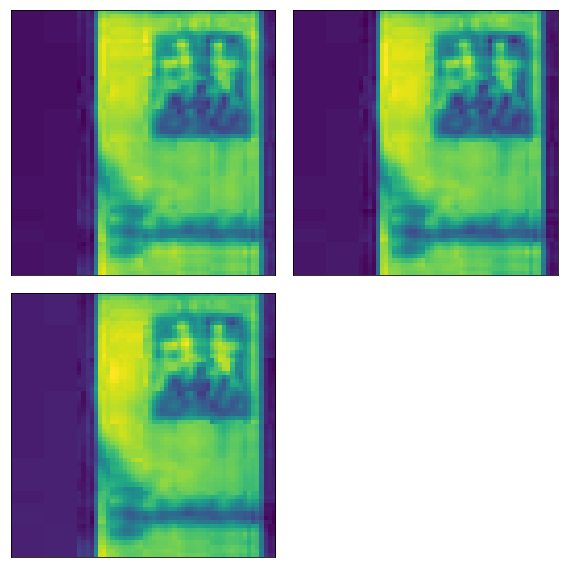

In [36]:
fig = plt.figure(figsize=(8,8))
for idx, i in enumerate(range(3)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(im[:,:,i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

In [42]:
gim = np.mean(im, axis=2)

In [43]:
gim.shape

(64, 64)

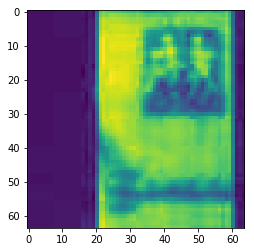

In [44]:
plt.imshow(gim)

In [115]:
im = imageio.imread(faces[0])

In [116]:
im.shape

(64, 64, 3)

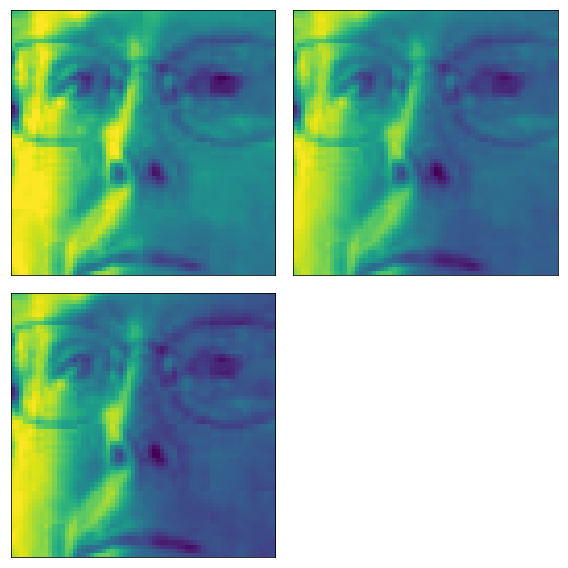

In [117]:
fig = plt.figure(figsize=(8,8))
for idx, i in enumerate(range(3)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(im[:,:,i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

### Q.1 Load function

In [74]:
def load_data(faces_dir=[], background_dir=[]):
    def gen_filelist(filedir='', keyward=''):
        return glob.glob(filedir+'/*'+keyward+'*.jpg')
    def img_preprocess(filedir=''):
        im = imageio.imread(filedir)
        gray_scale = im.mean(axis=2)
        return gray_scale
    # filelist
    faces = gen_filelist(filedir=faces_dir)
    backgrounds = gen_filelist(filedir=background_dir) 

    _fimgs = []
    _bimgs = []
    for ifile, jfile in zip(faces, backgrounds):
        _fimgs += [img_preprocess(ifile).reshape(1,64,64)]
        _bimgs += [img_preprocess(jfile).reshape(1,64,64)]
    
    imgs = np.concatenate(_fimgs+_bimgs, axis=0)
    labels = np.concatenate( (np.ones(len(_fimgs)),np.ones(len(_bimgs))) )
    return imgs, labels

In [75]:
imgs, labels= load_data(faces_dir=fcdatadir, background_dir=bgdatadir)

In [76]:
imgs.shape , labels.shape

((4000, 64, 64), (4000,))

### Q.2 Integral image filter

#### straight forwad method 

In [110]:
a = np.ones((3,3))
a[0,1] = 2
a[0,2] = 4
a[1,0] = 3
a[2,0] = 5
a[1,1] = 10
a[1,2] = 10
a[2,1] = 5
a[2,2] = 2
a

array([[ 1.,  2.,  4.],
       [ 3., 10., 10.],
       [ 5.,  5.,  2.]])

In [101]:
[i for i in range(1+1)]

[0, 1]

In [103]:
for i in range(1):
    print(i)

0


In [112]:
nx, ny = a.shape
int_img = np.ones((nx,ny))
int_img[0,0] = a[0,0]
for i in range(nx):
    for j in range(ny):
        if j > 0 and i > 0:
            int_img[i,j] = int_img[i-1,j] + sum([ a[i,k] for k in range(j+1)])
            print(i,j)
            print(int_img[i-1,j])
            print(sum([ a[i,k] for k in range(j+1)]))
        elif j==0 and i>0:
            int_img[i,0] = int_img[i-1,0] + a[i,0]
        elif i==0 and j>0:
            int_img[0,j] = int_img[0,j-1] + a[0,j]

1 1
3.0
13.0
1 2
7.0
23.0
2 1
16.0
10.0
2 2
30.0
12.0


In [113]:
int_img

array([[ 1.,  3.,  7.],
       [ 4., 16., 30.],
       [ 9., 26., 42.]])

### functionize

In [114]:
def compute_integral_image(imgs):
    """
    IN: imgs. np.ndarray, shape [#images, 64,64]
    """
    
    def _compute_int_img_unit(img):
        """
            compute integral image for one image 
        """
        nx, ny = img.shape
        int_img = np.ones((nx,ny))
        int_img[0,0] = img[0,0]
        for i in range(nx):
            for j in range(ny):
                if j > 0 and i > 0:
                    int_img[i,j] = int_img[i-1,j] + sum([ img[i,k] for k in range(j+1)])
                elif j==0 and i>0:
                    int_img[i,0] = int_img[i-1,0] + img[i,0]
                elif i==0 and j>0:
                    int_img[0,j] = int_img[0,j-1] + img[0,j]
        return int_img
    
    nimg, nx, ny = imgs.shape
    int_img_list = []
    for img in imgs:
        int_img_list += [_compute_int_img_unit(img).reshape(1,nx,ny)]
    int_imgs = np.concatenate(int_img_list, axis=0)
    return int_imgs

In [119]:
test_im = im.mean(axis=2).reshape(1,64,64)
test_int_img = compute_integral_image(test_im)

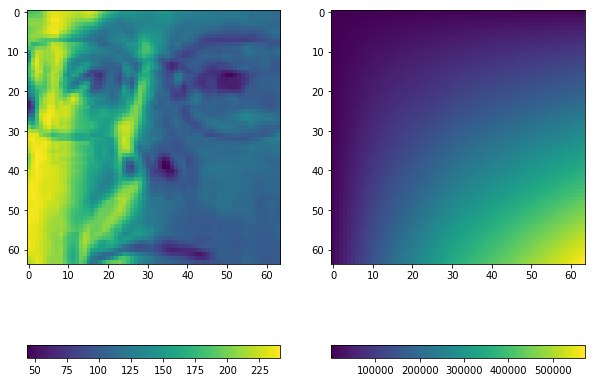

In [127]:
plt.figure(figsize=(10,10))
ax=plt.subplot(121)
plt.imshow(test_im[0])
plt.colorbar(orientation='horizontal')
ax = plt.subplot(122)
plt.imshow(test_int_img[0])
plt.colorbar(orientation='horizontal')

### Prep for Q.3 Reconstruction

In [153]:
def compute_reconst_img(_int_img):
    _, nx, ny = _int_img.shape
    int_img = _int_img[0]
    intensity = np.zeros((nx,ny))
    intensity[0,0] = int_img[0,0]
    for i in range(nx):
        for j in range(ny):
            if i > 0 and j > 0:
                intensity[i,j] = int_img[i,j] + int_img[i-1,j-1] - int_img[i,j-1] - int_img[i-1,j]
            elif i==0 and j > 0:
                intensity[0,j] = int_img[0,j] - int_img[0,j-1]
            elif j==0 and i > 0:
                intensity[i,0] = int_img[i,0] - int_img[i-1,0]
    return intensity

In [154]:
reconst_img = compute_reconst_img(test_int_img)

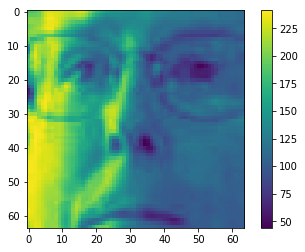

In [155]:
plt.imshow(reconst_img)
plt.colorbar()

In [156]:
res = test_im[0] - reconst_img

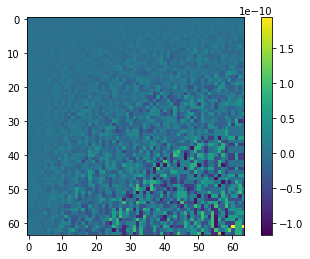

In [157]:
plt.imshow(res)
plt.colorbar()